In [1]:
import matplotlib.pyplot as py
import numpy as np

$M_{pl} = 1$, potentials $V = V_0\phi^k$, $H_{60} = 2.5\times10^{-5} M_{pl}$ simulating $H$ trajectories using HJ formalism, so $\frac{dH}{d\phi} = \sqrt{1.5H^2 - 0.5V}$

I'd like to ensure $\varepsilon > 0$. A quick check of the $H'$ vector field in the $\phi, H$ plane near the $\sqrt{\frac{1}{3}V}$ contour shows that $H'$ is a small, positive, number, so the vector field points such that as $\phi$ decreases the true $H$ trajectory can not intersect the $H = \sqrt{\frac{1}{3}V}$ contour. Hence, $\varepsilon < 0$ errors are artifacts of the scheme we were employing until now. We should be able to use an adaptive scheme to ensure this. 

In [2]:
grad_calc = lambda H, V0, phi, k: (1.5*(H**2) - 0.5*V0*(phi**k))**0.5
epsilon_calc = lambda  H, V0, phi, k: 2*(1.5*(H**2) - 0.5*V0*(phi**k))/(H**2)

The scheme employed below will ensure $\varepsilon >0$ provided the section of $H$ trajectory considered is convex as a function of $\phi$ 

We scale $H_0 \rightarrow H_0 \times 10^5 = \tilde{H_0}$, $V_0 \rightarrow V_0 \times 10^{10} = \tilde{V_0}$

In [7]:
def trajectory(V_0, k, phi_0, dphi0 = 0.00001, boundmultiplier = 100, H0 = 2.5, suppress = False):
    if not (3*(H0**2)/((phi_0)**k) > V_0 > 2*(H0**2)/((phi_0)**k) or suppress):
        raise Exception("wrong parameter choice")
    T =  int(phi_0/dphi0)
    phi = np.zeros(boundmultiplier*T+1)  #adapting mesh for phi
    H = np.zeros(boundmultiplier*T+1)
    phi[0] = phi_0
    H[0]  = H0
    epsilon = epsilon_calc(H[0], V_0, phi[0], k)
    n = 0
    dphi = dphi0
    #SPACE
    while (epsilon < 1) and (n < boundmultiplier*T):
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] - 0.5*dphi*K1, V_0, phi[n] - 0.5*dphi, k)
        K3 = grad_calc(H[n] - 0.5*dphi*K2, V_0, phi[n] - 0.5*dphi, k)
        K4 = grad_calc(H[n] - dphi*K3, V_0, phi[n] - dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        epsilon = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        dphi = min(0.9*(H[n+1] - ((V_0*(phi[n+1])**k)*(1/3))**0.5)/(grad_calc(H[n+1], V_0, phi[n+1], k)), dphi0)
        n += 1
    return phi[0:n+1], H[0:n+1], n, epsilon

In [ ]:
(2.5e-5)**2/(242*3) #Slow roll V_0

In [ ]:
#Select V_0
2.9*((2.5e-5)**2)/((15)**2)

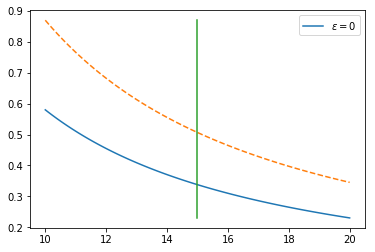

In [8]:
#consider choices of k
h60 = 2.5
k = 4/3
linechoice = 15

phi60 = np.linspace(10, 20, 101)
Vzero = [(h60**2)*2/(phi**k) for phi in phi60]
Vzero2 = [(h60**2)*3/(phi**k) for phi in phi60]

py.plot(phi60, Vzero, label = '$ε = 0$')
py.plot(phi60, Vzero2, '--')
py.plot(np.linspace(linechoice, linechoice, 11), np.linspace(Vzero[-1], Vzero2[0], 11))
py.legend()

We scale $H_0 \rightarrow H_0 \times 10^5 = \tilde{H_0}$, $V_0 \rightarrow V_0 \times 10^{10} = \tilde{V_0}$

n = 1440959
ε = 1.0000091755951883


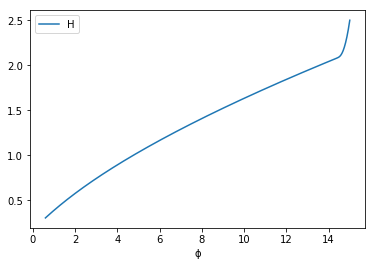

In [9]:
phi, H, n, epsilon = trajectory(0.37, 4/3, 15)
py.plot(phi, H, label='H')
py.xlabel('ϕ')
py.legend()
print("n =", n, end = '\n')
print("ε =", epsilon)

We had been choosing random initial $\phi_0$. Now we will check corresponding $N$ values integrate backwards while $N < N_{\mathrm{start}} \approx 60$

$N = \frac{1}{2}\int^{\phi_N}_{\phi_0}\sqrt{\frac{2}{\varepsilon}} d\phi$

In [10]:
def tot_traj(Nstart, V_0, k, phi_0 = 10, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5e-5, suppress = False):
    T = int(phi_0/dphi0)
    phiswap, Jswap, n0, epsilon = trajectory(V_0, k, phi_0, dphi0, boundmultiplier, H0, suppress)
    phi1, J1 = phiswap[::-1], Jswap[::-1]
    N = 0
    phi = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    phi[:n0 + 1] = phi1
    H[:n0 + 1] = J1
    ε[0] = epsilon
    n = 0
    while (N < Nstart) and (n < n0):
        dphi = phi[n+1] - phi[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N += dphi*(J1 + J2)/4
        n += 1
    #Space
    while (N < Nstart) and (n < boundmultiplier*T):
        dphi = min(0.5*(H[n] - ((V_0*(phi[n])**k)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], k)), dphi0)
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k)
        K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k)
        K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] + dphi*grad
        phi[n+1] = phi[n] + dphi
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        #SPACE
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N += dphi*(J1 + J2)/4
        n += 1
    return phi[:n+1], H[:n+1], n, ε[:n+1], N

Inflation should end at $\varepsilon = 1$ - we will require this later, but for now we shall end inflation at $N = N_{\mathrm{start}}$

n = 230135
N = 60.000009487592756
Full trajectory not available via this method - ε > 1 at n = 144282


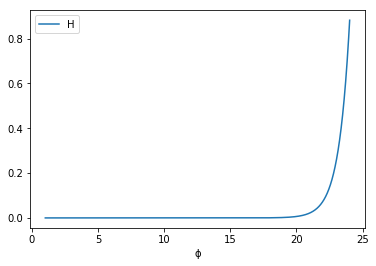

In [12]:
phi, H, n, epsilon, N = tot_traj(60, 8e-12, 2, 15, suppress = True)
py.plot(phi, H, label='H')
#py.plot(phi, epsilon, label='ε')
py.xlabel('ϕ')
py.legend()
print("n =", n, end = '\n')
print("N =", N, end = '\n')
for i, el in enumerate(epsilon):
    if el >1 and i>0:
        print("Full trajectory not available via this method - ε > 1 at n = %s"%i)
        break